# Train a deep SNN on the SHD Dataset

In [25]:
import os
import sys
sys.path.append("../../")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import stork.datasets
from stork.datasets import HDF5Dataset, DatasetView

from stork.loss_stacks import SumOfSoftmaxCrossEntropy
from stork.layers import Layer
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import FluctuationDrivenCenteredNormalInitializer, DistInitializer

# TEST SOFTMAX

In [26]:
b = 256
t = 350
n = 20

x = torch.randn((b,t,n))

torch.nn.Softmax(dim=-1)(x).sum(dim=-1)

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])

## Load Dataset

***To locally run this notebook on your system, download the SHD dataset from: [https://zenkelab.org/datasets/](https://zenkelab.org/datasets/).***
*We need 'shd_train.h5' and 'shd_test.h5'. Move the downloaded files into a folder `data/datasets/hdspikes` in this repo, or change the `datadir` variable below. 

In [27]:
datadir = "./data/datasets/hdspikes"

Next, we specify the Dataset Parameters.

In [28]:
nb_inputs = 700
duration = 0.7
time_step = dt = 2e-3
nb_time_steps = int(duration / time_step)
time_scale = 1
unit_scale = 1
validation_split = 0.9

In [29]:
gen_kwargs = dict(
    nb_steps=nb_time_steps,
    time_scale=time_scale / time_step,
    unit_scale=unit_scale,
    nb_units=nb_inputs,
    preload=True,
    precompute_dense=False,
    unit_permutation=None
    )

In [30]:
train_dataset = HDF5Dataset(os.path.join(datadir, "shd_train.h5"), **gen_kwargs)

# Split into train and validation set
mother_dataset = train_dataset
elements = np.arange(len(mother_dataset))
np.random.shuffle(elements)
split = int(validation_split * len(mother_dataset))
valid_dataset = DatasetView(mother_dataset, elements[split:])
train_dataset = DatasetView(mother_dataset, elements[:split])

test_dataset = HDF5Dataset(os.path.join(datadir, "shd_test.h5"), **gen_kwargs)

## Set up the model

In [31]:
# Model Parameters
batch_size = 256
beta = 20
device = torch.device("cuda:1")
dtype = torch.float


nb_hidden_units = 1024
nb_hidden_layers = 1
nb_classes = 20

tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = 200e-3

lr = 0.0001
nb_epochs = 100

In [32]:
act_fn = stork.activations.SuperSpike
act_fn.beta = beta
neuron_group = LIFGroup

model = RecurrentSpikingModel(
    batch_size,
    nb_time_steps,
    nb_inputs,
    device,
    dtype)

Create regularizers

In [33]:
# Define regularizer parameters (set regularizer strenght to 0, if you don't want to use them)
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0
upperBoundL2Threshold = 7       # Regularizes spikecount: 7 spikes ~ 10 Hz in 700ms simulation time

# Define regularizer list
regs = []

regLB = stork.regularizers.LowerBoundL2(lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False)
regs.append(regLB)
regUB = stork.regularizers.UpperBoundL2(upperBoundL2Strength,threshold=upperBoundL2Threshold, dims=1)
regs.append(regUB)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [34]:
sigma_u = 0.7
nu = 15.8

initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u = sigma_u, 
    nu=nu, 
    timestep = dt
    )

readout_initializer = DistInitializer()

Add input neuron group

In [35]:
input_group = model.add_group(InputGroup(nb_inputs, dropout_p=0.4))

Now we want to add multiple hidden layers as well as regularizers for them

In [36]:
upstream_group = input_group

for l in range(nb_hidden_layers):

    hidden_layer = Layer(
        'hidden',
        model, 
        nb_hidden_units, 
        upstream_group,
        recurrent=True,
        regs=regs,
        neuron_kwargs=dict(
            tau_mem=tau_mem,
            tau_syn=tau_syn,
            activation=act_fn,
            dropout_p=0.4),
    )
    
    upstream_group = hidden_layer.output_group
    
    initializer.initialize(hidden_layer)

readout_group = model.add_group(ReadoutGroup(
    nb_classes,
    tau_mem=tau_readout,
    tau_syn=tau_syn,
    initial_state=-1e-2))

con_ro = model.add_connection(Connection(upstream_group, readout_group))
readout_initializer.initialize(con_ro)

Add monitors for spikes and membrane potential

In [37]:
for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.SpikeCountMonitor(model.groups[1 + i]))

for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.StateMonitor(model.groups[1 + i], "out"))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [38]:
loss_stack = SumOfSoftmaxCrossEntropy()

We select the SMORMS3 optimizer

In [39]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=2)

In [40]:
model.configure(input=input_group,
                output=readout_group,
                loss_stack=loss_stack,
                generator=generator,
                optimizer=opt,
                optimizer_kwargs=dict(lr=lr),
                time_step=dt)

Before we train the model, we monitor the spikes (ca. 20s)

In [41]:
# Monitors spike counts before training
results = {}
res = model.monitor(test_dataset)
total_spikes_per_layer = [torch.sum(res[i]).item()for i in range(nb_hidden_layers)]
results["avg_layer_freq_init"] = [nb/len(test_dataset)/duration/nb_hidden_units for nb in total_spikes_per_layer]

print(results)

{'avg_layer_freq_init': [12.267249317737255]}


In [42]:
model.groups[1].get_flattened_out_sequence().shape

torch.Size([216, 349, 1024])

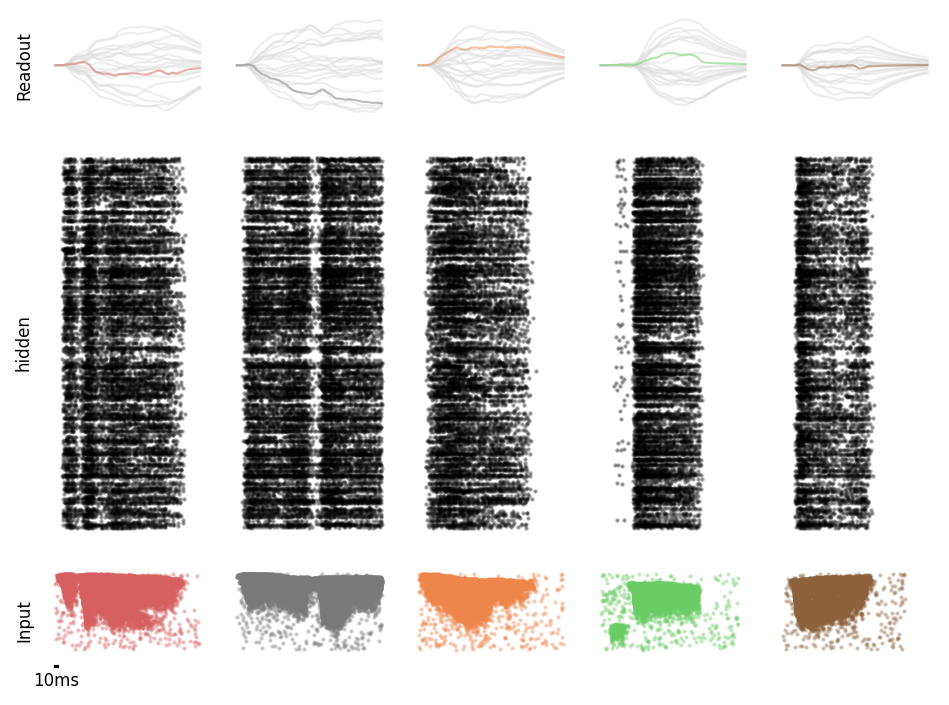

In [43]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model,
    data=test_dataset,
    nb_samples=5,
    point_alpha=0.3)

## Train

It takes around 50 min using a powerful GPU

In [44]:
history = model.fit_validate(
    train_dataset,
    valid_dataset,
    nb_epochs=nb_epochs,
    verbose=True)

results["train_loss"] = history["loss"].tolist()
results["train_acc"] = history["acc"].tolist()
results["valid_loss"] = history["val_loss"].tolist()
results["valid_acc"] = history["val_acc"].tolist()

00  loss=4 reg_loss=2.89e-05 acc=0.0708 -- val_loss=2.85 val_reg_loss=3.9e-05 val_acc=0.132 t_iter=9.92
01  loss=2.87 reg_loss=2.8e-05 acc=0.136 -- val_loss=2.51 val_reg_loss=3.81e-05 val_acc=0.177 t_iter=9.88
02  loss=2.59 reg_loss=2.68e-05 acc=0.201 -- val_loss=2.24 val_reg_loss=3.69e-05 val_acc=0.272 t_iter=9.98
03  loss=2.36 reg_loss=2.54e-05 acc=0.26 -- val_loss=2.21 val_reg_loss=3.53e-05 val_acc=0.3 t_iter=9.92
04  loss=2.19 reg_loss=2.41e-05 acc=0.309 -- val_loss=1.99 val_reg_loss=3.39e-05 val_acc=0.346 t_iter=9.96
05  loss=2.04 reg_loss=2.29e-05 acc=0.349 -- val_loss=1.76 val_reg_loss=3.26e-05 val_acc=0.444 t_iter=10.08
06  loss=1.92 reg_loss=2.18e-05 acc=0.382 -- val_loss=1.76 val_reg_loss=3.15e-05 val_acc=0.44 t_iter=9.98
07  loss=1.79 reg_loss=2.08e-05 acc=0.418 -- val_loss=1.6 val_reg_loss=3.03e-05 val_acc=0.481 t_iter=9.95
08  loss=1.69 reg_loss=1.98e-05 acc=0.454 -- val_loss=1.51 val_reg_loss=2.92e-05 val_acc=0.519 t_iter=10.16
09  loss=1.64 reg_loss=1.92e-05 acc=0.461 --

Monitor the model again after training

In [ ]:
res = model.monitor(test_dataset)
total_spikes_per_layer = [torch.sum(res[i]).item()for i in range(nb_hidden_layers)]
results["avg_layer_freq"] = [nb/len(test_dataset)/duration/nb_hidden_units for nb in total_spikes_per_layer]


## Test

In [ ]:
scores = model.evaluate(test_dataset).tolist()
results["test_loss"], _, results["test_acc"] = scores

Test loss:  0.736997644106547
Test acc.:  0.9014435442386832


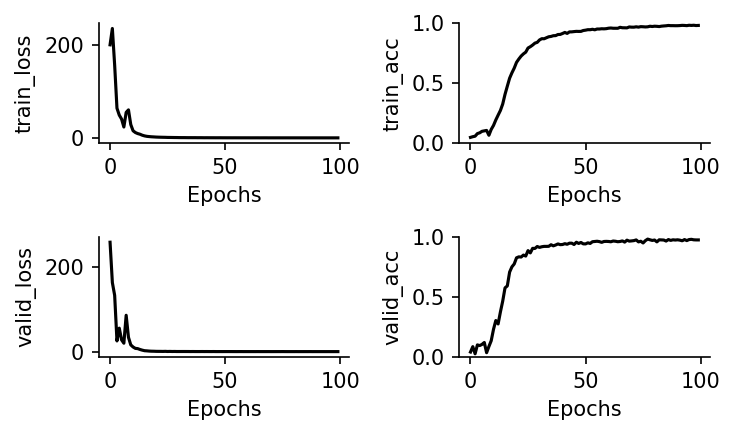

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(5,3), dpi=150)

for i, n in enumerate(["train_loss", "train_acc", "valid_loss", "valid_acc"]):
    
    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i-2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"])
print("Test acc.: ", results["test_acc"])

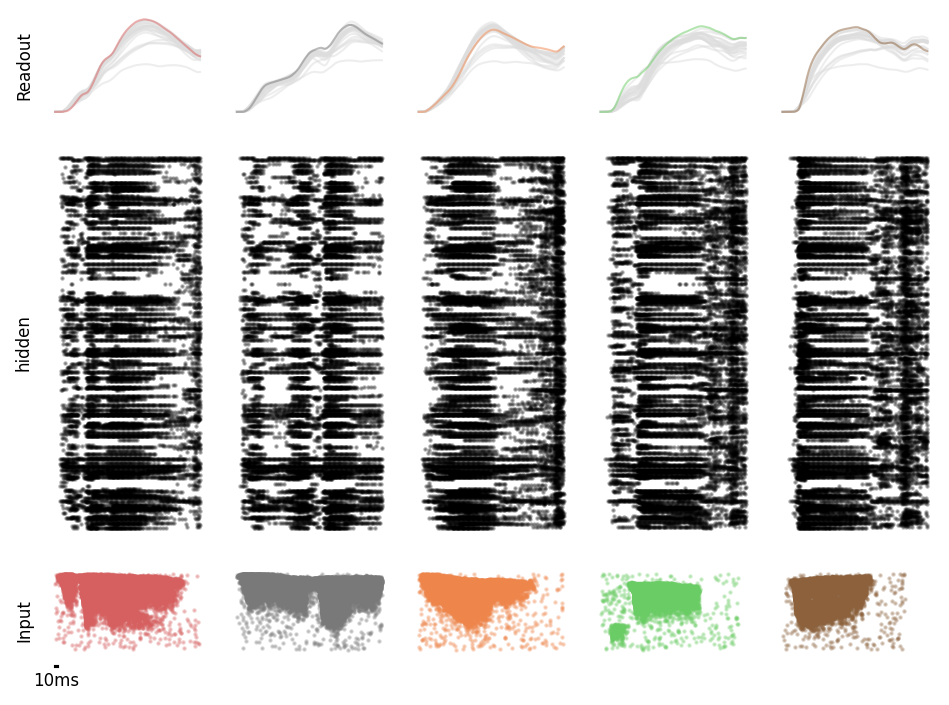

In [ ]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model,
    data=test_dataset,
    nb_samples=5,
    point_alpha=0.3)